# Explainability Analysis

This notebook performs explainability analysis using LIME for the best-performing model:
- Model: `logistic_regression.pkl` (Mutual Info Regression feature set)

In [1]:
import os
import warnings
from pathlib import Path
import re
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import MinMaxScaler

MODEL_PATH = Path("../models/ml2/mir/logistic_regression.pkl")
TRAIN_PATH = Path("../data/processed/features2/mir/train.csv")
TEST_PATH = Path("../data/processed/features2/mir/test.csv")

SAVE_DATA_DIR = Path("../data/processed/explainability")
SAVE_FIG_DIR  = Path("../figures/explainability")
LOCAL_DATA_DIR = SAVE_DATA_DIR / "local"
GLOBAL_DATA_DIR = SAVE_DATA_DIR / "global"
LOCAL_FIG_DIR = SAVE_FIG_DIR / "local"
GLOBAL_FIG_DIR = SAVE_FIG_DIR / "global"

for p in [SAVE_DATA_DIR, SAVE_FIG_DIR, LOCAL_DATA_DIR, GLOBAL_DATA_DIR, LOCAL_FIG_DIR, GLOBAL_FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

warnings.filterwarnings("ignore", category=UserWarning)

print("Folders are ready:")
print("  data:", SAVE_DATA_DIR)
print("  figures:", SAVE_FIG_DIR)

Folders are ready:
  data: ..\data\processed\explainability
  figures: ..\figures\explainability


## Load model and data

In [2]:
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

model = joblib.load(MODEL_PATH)

feature_cols = [
    'PSS4', 'PSS10', 'PSS2', 'PSS1', 'PSS9', 'PSS3', 'PSS5',
    'PHQ2', 'PHQ6', 'PHQ4', 'PHQ7', 'PHQ9', 'PHQ5'
]

missing = [c for c in feature_cols if c not in train_df.columns]
if missing:
    raise ValueError("Missing features in train/test CSVs: " + ", ".join(missing))

print("Model and data loaded.")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Model and data loaded.
Train shape: (1617, 14)
Test shape: (405, 14)


## Human readable mapping for features

In [3]:
feature_human_map = {
    'PSS1': 'Emotional Response to Setbacks',
    'PSS2': 'Sense of Control Over Academics',
    'PSS3': 'Overall Academic Stress Level',
    'PSS4': 'Confidence in Coping Abilities',
    'PSS5': 'Problem-Solving Self-Efficacy',
    'PSS6': 'Perception of Academic Progress',
    'PSS7': 'Tolerance for Academic Frustration',
    'PSS8': 'Academic Self-Confidence',
    'PSS9': 'Frustration With Academic Results',
    'PSS10': 'Sense of Academic Helplessness',
    'PHQ1': 'Loss of Interest',
    'PHQ2': 'Low Mood or Hopelessness',
    'PHQ3': 'Sleep Difficulties',
    'PHQ4': 'Fatigue or Low Energy',
    'PHQ5': 'Appetite or Weight Changes',
    'PHQ6': 'Feelings of Worthlessness',
    'PHQ7': 'Difficulty Concentrating',
    'PHQ8': 'Psychomotor Changes',
    'PHQ9': 'Suicidal Thoughts'
}

feature_human = [feature_human_map.get(f, f) for f in feature_cols]

## Prepare data for LIME

In [4]:
scaler = MinMaxScaler()

X_train = train_df[feature_cols].values.astype(float)
y_train = train_df["DepressionEncoded"].values.astype(int)

X_test = test_df[feature_cols].values.astype(float)
y_test = test_df["DepressionEncoded"].values.astype(int)

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling done. Example scaled sample (first 5 values):", X_train_scaled[0][:5])

Scaling done. Example scaled sample (first 5 values): [0.75 0.5  0.5  0.5  0.5 ]


## Create LIME Tabular Explainer

In [5]:
class_names = ["Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]

explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=feature_cols,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True
)

print("LIME explainer ready.")

LIME explainer ready.


## Wrapper predict function for LIME

In [6]:
def predict_fn_numpy(X):
    X_arr = np.array(X)
    if X_arr.ndim == 1:
        X_arr = X_arr.reshape(1, -1)
    X_orig = scaler.inverse_transform(X_arr)
    X_df = pd.DataFrame(X_orig, columns=feature_cols)
    probs = model.predict_proba(X_df)
    return probs

p = predict_fn_numpy(X_test_scaled[:2])
print("predict_fn_numpy output shape:", p.shape)

predict_fn_numpy output shape: (2, 5)


## Select one sample per class

In [7]:
samples = {}
for cls in range(len(class_names)):
    rows = test_df[test_df["DepressionEncoded"] == cls]
    if rows.shape[0] >= 1:
        samples[cls] = rows.sample(1, random_state=42).iloc[0]
    else:
        print(f"Warning: no sample found for class {cls}")

print("Selected classes with available samples:", list(samples.keys()))

Selected classes with available samples: [0, 1, 2, 3, 4]


## Local explanations loop

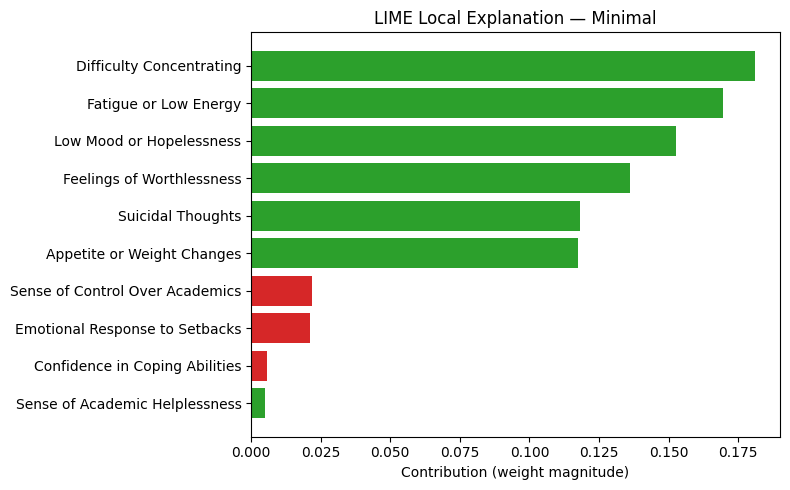

Saved local explanation for class 0 → HTML: ..\data\processed\explainability\local\lime_explanation_class_0.html, PNG: ..\figures\explainability\local\lime_local_class_0.png, CSV: ..\data\processed\explainability\local\lime_local_class_0.csv


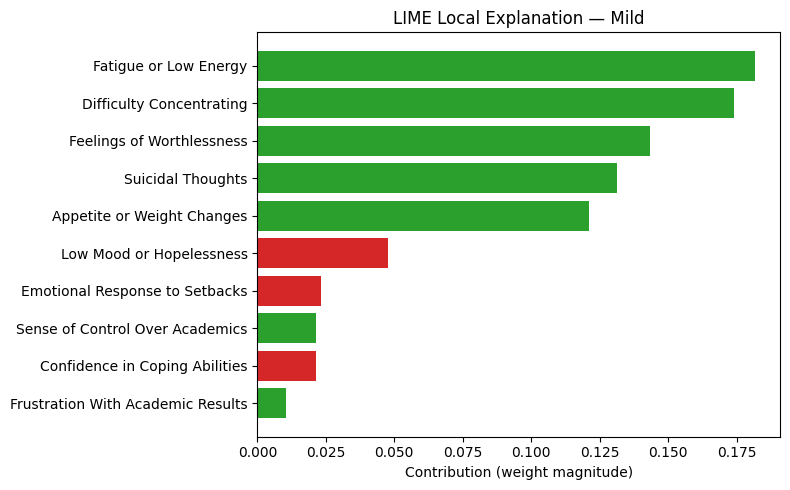

Saved local explanation for class 1 → HTML: ..\data\processed\explainability\local\lime_explanation_class_1.html, PNG: ..\figures\explainability\local\lime_local_class_1.png, CSV: ..\data\processed\explainability\local\lime_local_class_1.csv


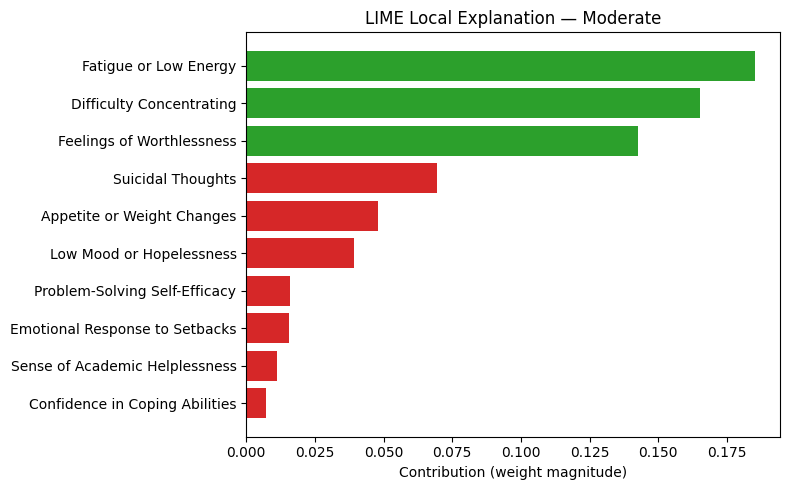

Saved local explanation for class 2 → HTML: ..\data\processed\explainability\local\lime_explanation_class_2.html, PNG: ..\figures\explainability\local\lime_local_class_2.png, CSV: ..\data\processed\explainability\local\lime_local_class_2.csv


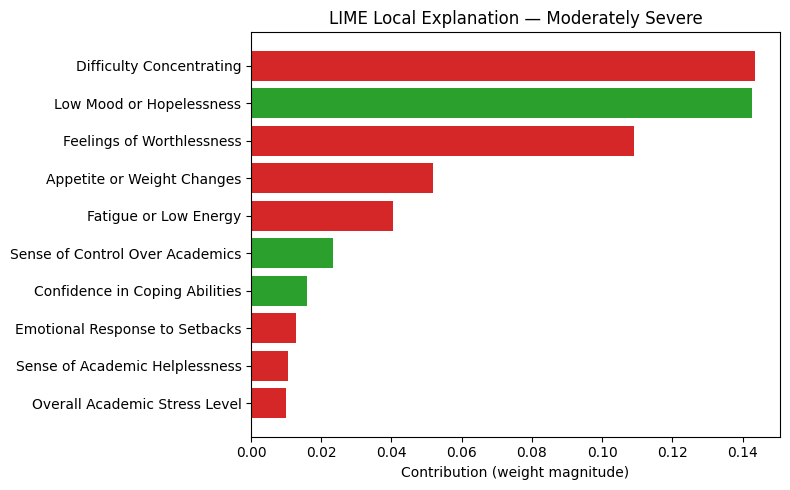

Saved local explanation for class 3 → HTML: ..\data\processed\explainability\local\lime_explanation_class_3.html, PNG: ..\figures\explainability\local\lime_local_class_3.png, CSV: ..\data\processed\explainability\local\lime_local_class_3.csv


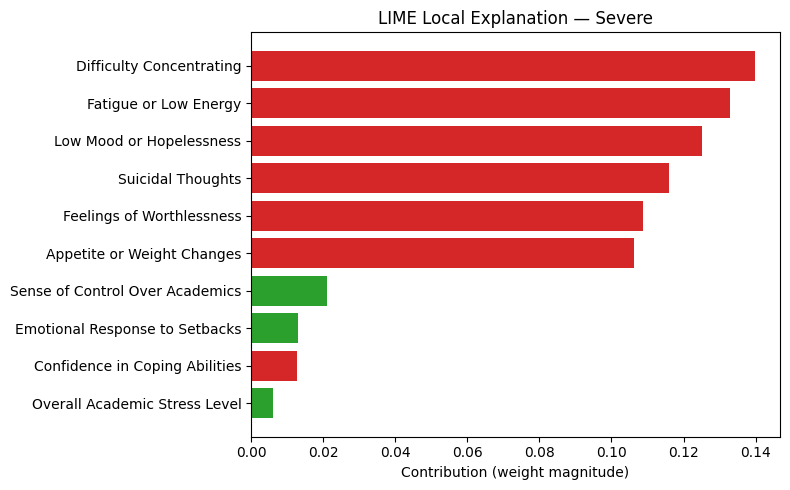

Saved local explanation for class 4 → HTML: ..\data\processed\explainability\local\lime_explanation_class_4.html, PNG: ..\figures\explainability\local\lime_local_class_4.png, CSV: ..\data\processed\explainability\local\lime_local_class_4.csv
Saved combined local explanations CSV.


In [8]:
def extract_feature_name(lime_feat_str):
    tokens = re.findall(r"[A-Za-z]+[0-9]+", lime_feat_str)
    if tokens:
        return tokens[0]
    tokens2 = re.findall(r"[A-Za-z_]+", lime_feat_str)
    return tokens2[0] if tokens2 else lime_feat_str

local_rows = []
for cls, row in samples.items():
    idx = int(row.name)
    x_orig = row[feature_cols].values.astype(float)
    x_scaled = scaler.transform(x_orig.reshape(1, -1))[0]

    exp = explainer.explain_instance(
        data_row=x_scaled,
        predict_fn=predict_fn_numpy,
        num_features=10
    )

    html_path = LOCAL_DATA_DIR / f"lime_explanation_class_{cls}.html"
    exp.save_to_file(str(html_path))

    explanation_list = exp.as_list()
    feat_bases = []
    feat_descs = []
    weights = []
    for feat_str, wt in explanation_list:
        base = extract_feature_name(feat_str)
        if base not in feature_cols:
            continue
        feat_bases.append(base)
        feat_descs.append(feature_human_map.get(base, base))
        weights.append(wt)

    if len(feat_bases) == 0 and explanation_list:
        for feat_str, wt in explanation_list:
            base = extract_feature_name(feat_str)
            feat_bases.append(base)
            feat_descs.append(feature_human_map.get(base, base))
            weights.append(wt)

    fig, ax = plt.subplots(figsize=(8,5))
    colors = ['tab:green' if w>0 else 'tab:red' for w in weights]
    ax.barh(feat_descs[::-1], [abs(w) for w in weights[::-1]], color=colors[::-1])
    ax.set_title(f"LIME Local Explanation — {class_names[cls]}")
    ax.set_xlabel("Contribution (weight magnitude)")
    plt.tight_layout()
    fig_path = LOCAL_FIG_DIR / f"lime_local_class_{cls}.png"
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    df_local = pd.DataFrame({
        "class": cls,
        "class_name": class_names[cls],
        "feature_raw": [s for s,_ in explanation_list],
        "feature_base": feat_bases,
        "feature_desc": feat_descs,
        "weight": weights
    })
    csv_path = LOCAL_DATA_DIR / f"lime_local_class_{cls}.csv"
    df_local.to_csv(csv_path, index=False)

    local_rows.append(df_local)
    print(f"Saved local explanation for class {cls} → HTML: {html_path}, PNG: {fig_path}, CSV: {csv_path}")

if local_rows:
    pd.concat(local_rows, ignore_index=True).to_csv(LOCAL_DATA_DIR / "local_explanations_all.csv", index=False)
    print("Saved combined local explanations CSV.")

## Global aggregation

In [9]:
N_SAMPLES = min(200, len(test_df))
print("Global aggregation will use", N_SAMPLES, "samples.")

global_weights = {f: [] for f in feature_cols}

subset = test_df.sample(N_SAMPLES, random_state=42).reset_index(drop=True)

for i in range(len(subset)):
    row = subset.loc[i]
    x_scaled = scaler.transform(row[feature_cols].values.reshape(1,-1))[0]
    exp = explainer.explain_instance(x_scaled, predict_fn_numpy, num_features=len(feature_cols))
    for feat_str, wt in exp.as_list():
        base = extract_feature_name(feat_str)
        if base in global_weights:
            global_weights[base].append(abs(wt))

global_mean = {f: (np.mean(global_weights[f]) if len(global_weights[f])>0 else 0.0) for f in feature_cols}

global_df = pd.DataFrame({
    "feature": list(global_mean.keys()),
    "importance": list(global_mean.values())
}).sort_values("importance", ascending=False)

global_df["feature_desc"] = global_df["feature"].map(lambda x: feature_human_map.get(x, x))

global_csv_path = GLOBAL_DATA_DIR / "global_importance_lime.csv"
global_df.to_csv(global_csv_path, index=False)
global_df

Global aggregation will use 200 samples.


,feature,importance,feature_desc
10,PHQ7,0.137133,Difficulty Concentrating
9,PHQ4,0.119729,Fatigue or Low Energy
7,PHQ2,0.110740,Low Mood or Hopelessness
8,PHQ6,0.105642,Feelings of Worthlessness
12,PHQ5,0.103108,Appetite or Weight Changes
11,PHQ9,0.089171,Suicidal Thoughts
2,PSS2,0.020796,Sense of Control Over Academics
3,PSS1,0.013584,Emotional Response to Setbacks
0,PSS4,0.011714,Confidence in Coping Abilities
1,PSS10,0.011038,Sense of Academic Helplessness


## Plot global importance

C:\Users\ryo\AppData\Local\Temp\ipykernel_19536\578514806.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature_desc", data=global_df, palette="viridis")


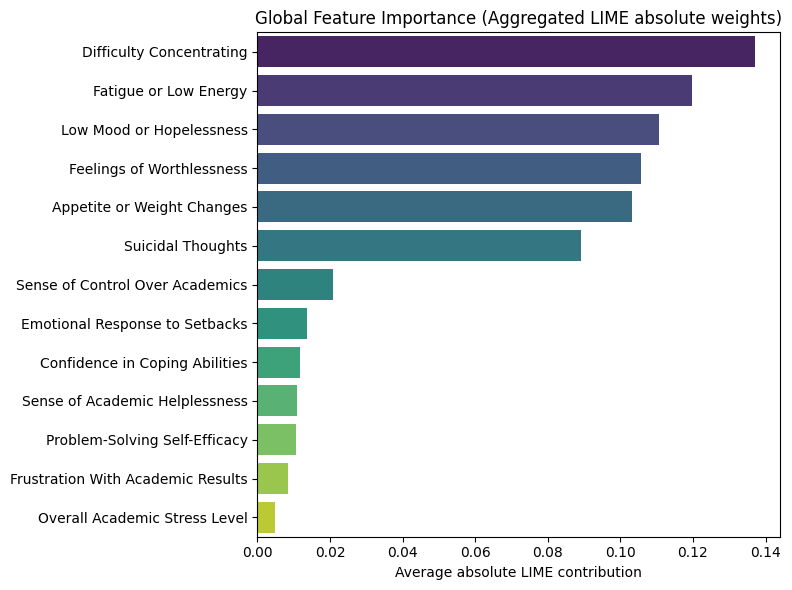

Saved global plot to: ..\figures\explainability\global\global_importance_lime.png


In [10]:
plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature_desc", data=global_df, palette="viridis")
plt.title("Global Feature Importance (Aggregated LIME absolute weights)")
plt.xlabel("Average absolute LIME contribution")
plt.ylabel("")
plt.tight_layout()
global_fig_path = GLOBAL_FIG_DIR / "global_importance_lime.png"
plt.savefig(global_fig_path, dpi=300, bbox_inches='tight')
plt.show()
print("Saved global plot to:", global_fig_path)